# Titanic Survivor Prediction problem

##### Importing required modules.

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
sns.set()
import warnings
warnings.filterwarnings('ignore',category = DeprecationWarning)

###### Reading the Dataset and Exploring

In [40]:
titanic = pd.read_csv('train.csv')
titanic_copy = titanic.copy()

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- ###### Checking whether embarked place of a person has any effect on his survival rate 
- ###### This is based on the assumption that the people who embarked ship early are more likely to rest and new comers tend to explore the ship and thus could escape a bit fast

In [41]:
titanic[titanic.Embarked == 'C'].Survived.value_counts(),titanic[titanic.Embarked == 'S'].Survived.value_counts(),titanic[titanic.Embarked == 'Q'].Survived.value_counts()

(1    93
 0    75
 Name: Survived, dtype: int64, 0    427
 1    217
 Name: Survived, dtype: int64, 0    47
 1    30
 Name: Survived, dtype: int64)

###### Replacing the embarked with column with respective weights. weights obtained by their survival ratio

In [42]:
titanic.replace(['S','Q','C'],[50,63,77],inplace = True)
titanic.Cabin.isnull().value_counts()

# So we can comfortably eliminate Cabin values because 687 cabins have no value

True     687
False    204
Name: Cabin, dtype: int64

In [43]:
titanic.loc[:,['SibSp','Parch','Survived']]

# Checking the relation between family members onboard and their survival rate
# This assuming there is a high chance of a family surviving if single member of their family survives


titanic[(titanic['SibSp'] == 0) & (titanic['Parch'] == 0)].Survived.value_counts()

# Obtaining value_counts is to get a survival ratio so that we can replace it in place of these two columns.

0    374
1    163
Name: Survived, dtype: int64

In [44]:
titanic[(~(titanic['SibSp'] == 0) | ~(titanic['Parch'] == 0))].Survived.value_counts()

1    179
0    175
Name: Survived, dtype: int64

###### adding a new column capturing the effects of two columns SibSp and Parch

In [45]:
titanic['Family'] = [1 if (titanic.SibSp[i] == 0 & titanic.Parch[i] == 0) else 2.4 for i in range(len(titanic.PassengerId))]

###### Dropping useless columns (Though we can still get information from name considering the complexities involved it is left out)

In [46]:
titanic.drop(['Name','SibSp','Parch','Ticket','Fare','Cabin'],axis = 1,inplace = True)

###### Survival ratio of a female is 4 times that of male so assigning numerical weights replacing 'male' and 'female'
###### Class is also modified accordingly

In [47]:
titanic['Pclass'] = 4 - titanic.Pclass
titanic['Sex'] = [1 if titanic.Sex[i] == 'male' else 4 for i in range(len(titanic['PassengerId']))]

###### Filling missing age values though it is not generally advisable it is done here to simplify the process

In [48]:
titanic.Age.fillna(method = 'bfill',inplace = True)

###### Binning so as to it will help in future to assign weights to ages

In [49]:
titanic['Bins'] = (pd.cut(titanic.Age,8,retbins = True)[0])

In [50]:
k = []
for i in [4,14,24,34,44,54,64,74]:
    k.append(titanic.groupby('Bins').Survived.value_counts()[i][1]/titanic.groupby('Bins').Survived.value_counts()[i][0])

# Grouping by bins and then calling survived which has two rows one for '1' and other for '0'.
# This is basically to obtain a ratio of survival to bin.

In [51]:
k

# This is the survival ratio in particular bins.

[1.075,
 0.6071428571428571,
 0.55865921787709494,
 0.63709677419354838,
 0.59722222222222221,
 0.54838709677419351,
 0.61538461538461542,
 0.16666666666666666]

###### This following step is to replace the weights for ages based on bins

In [52]:
titanic_hf = titanic.sort_values(by = 'Bins')
ages = [4,14,24,34,44,54,64,74]
titanic_hf['Age_group'] = [titanic.groupby('Bins').Survived.value_counts()[i].sum() for i in titanic_hf.Age]

In [53]:
titanic_hf.Age_group.unique()

array([ 83, 135, 279, 203, 115,  48,  21,   7], dtype=int64)

###### Feature Scaling

In [54]:
titanic_hf.Age_group.replace(titanic_hf.Age_group.unique(),k,inplace = True)
titanic_hf['Embarked'] = titanic.Embarked/20
titanic_hf['Age_group'] = titanic_hf.Age_group*10
titanic_hf.drop(['Age','Bins'],axis = 1,inplace = True)

** Resorting values again based on PassengerID**

In [55]:
titanic_hf.sort_values('PassengerId',inplace = True)
#titanic_hf['Pclass'].replace([2,3],[3,5],inplace = True)
titanic_hf['hypothesis'] = titanic_hf.Pclass*titanic_hf.Sex*titanic_hf.Embarked*titanic_hf.Family*titanic_hf.Age_group
#titanic_hf

In [56]:
titanic_hf.dropna(inplace = True)
len(titanic_hf)

889

In [57]:
titanic_hf.hypothesis = titanic_hf.hypothesis.astype(int,inplace = True)
titanic_hf.to_csv('cross_check.csv')

#### Predicting Process.

In [58]:
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

In [59]:
from sklearn import cross_validation
X_train,X_test,y_train,y_test = tts(titanic_hf.hypothesis,titanic_hf.Survived,random_state = 5)
#cv = cross_validation.KFold(len(X_train),n_folds = 10)
#cross_validation.cross_val_score(dtc(),titanic_hf.hypothesis,titanic_hf.Survived,cv = 10)
#X_train.shape,X_test.shape,y_train.shape,y_test.shape

###### Prediction through decision tree and its accuracy score on the cross validated set

In [60]:
dt = dtc(random_state = 0,max_depth=None)
dt.fit(X_train.reshape(666,1),y_train.reshape(666,1))

dt.predict(X_test.reshape(223,1))

from sklearn.metrics import accuracy_score

accuracy_score(dt.predict(X_test.reshape(223,1)),y_test)

0.82959641255605376

###### Prediction through random forest and its accuracy score on the cross validated set

In [61]:
from sklearn.ensemble import RandomForestClassifier as RF

In [62]:
rf = RF()
rf.fit(X_train.reshape(666,1),y_train.reshape(666,1))


y_pred = rf.predict(X_test.reshape(223,1))

accuracy_score(y_pred,y_test)

0.83856502242152464

###### Prediction through Logistic regression and its accuracy score on the cross validated set

In [63]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR()
lr.fit(X_train.reshape(666,1),y_train.reshape(666,1))
accuracy_score(lr.predict(X_test.reshape(223,1)),y_test)

0.7982062780269058

###### Prediction through Support vector machine and its accuracy score on the cross validated set

In [64]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train.reshape(666,1),y_train.reshape(666,1))
accuracy_score(svc.predict(X_test.reshape(223,1)),y_test)

0.84753363228699552

###### Because we modified our train set already we are just replicating steps here on test set

In [65]:
test = pd.read_csv('test.csv')
test.replace(['S','Q','C'],[50,63,77],inplace = True)
test.loc[:,['SibSp','Parch']]
test['Family'] = [1 if (test.SibSp[i] == 0 & test.Parch[i] == 0) else 2.4 for i in range(len(test.PassengerId))]
test.drop(['Name','SibSp','Parch','Ticket','Fare','Cabin'],axis = 1,inplace = True)
test['Pclass'] = 4 - test.Pclass
test['Sex'] = [1 if test.Sex[i] == 'male' else 4 for i in range(len(test['PassengerId']))]
test.Age.fillna(method = 'ffill',inplace = True)
test['Bins'] = (pd.cut(test.Age,8,retbins = True)[0])
vals = test.Bins.unique()


## This step is a bit different to that performed on the train set

lst = zip(k,vals)
keys = dict(zip(k,vals))
keys_r = {y:x for x,y in keys.items()}
age_weight = []
for j in range(len(test.Age)):
    for i in keys_r.keys():
        if test.Age[j] in i:
            age_weight.append(keys_r[i])
        else:    
            continue            
test['Age_group'] = pd.Series(age_weight)
test['Embarked'] = titanic.Embarked/20
test['Age_group'] = test.Age_group*10
test.drop(['Age','Bins'],axis = 1,inplace = True)
test.sort_values('PassengerId',inplace = True)
#test['Pclass'].replace([2,3],[3,5],inplace = True)
test.Embarked.fillna(9.5,inplace = True)
test['hypothesis'] = test.Pclass*test.Sex*test.Embarked*test.Family*test.Age_group

###### We are here just adding our predictions to the csv file to submit in kaggle

- Though on cross validated set SVC,Decision tree and random forests fared better it is logistic regression that gave highest accuracy on our test set.

In [66]:
test.hypothesis = test.hypothesis.astype(int,inplace = True)
y_pred = dt.predict(test.hypothesis.reshape(418,1))
test['Survived'] = pd.Series(y_pred)

sub = test[['PassengerId','Survived']]
#sub.dropna(inplace = True)
test.to_csv('submission2.csv',index = None)

In [67]:
y_pred = rf.predict(test.hypothesis.reshape(418,1))
test['Survived'] = pd.Series(y_pred)

sub = test[['PassengerId','Survived']]
#sub.dropna(inplace = True)
sub.to_csv('submission2_rf.csv',index = None)

In [68]:
y_pred = lr.predict(test.hypothesis.reshape(418,1))
test['Survived'] = pd.Series(y_pred)

sub = test[['PassengerId','Survived']]
sub.to_csv('submission2_lr.csv',index = None)

In [69]:
y_pred = svc.predict(test.hypothesis.reshape(418,1))
test['Survived'] = pd.Series(y_pred)
sub = test[['PassengerId','Survived']]
sub.to_csv('submission2_svc.csv',index = None)

In [70]:
titan = titanic_hf.copy()
y_pred = lr.predict(titan.hypothesis.reshape(889,1))
titan['Survived_pred'] = pd.Series(y_pred)

###### Further more exploring the data so as to discover any normal method that can be used to predict using score we got

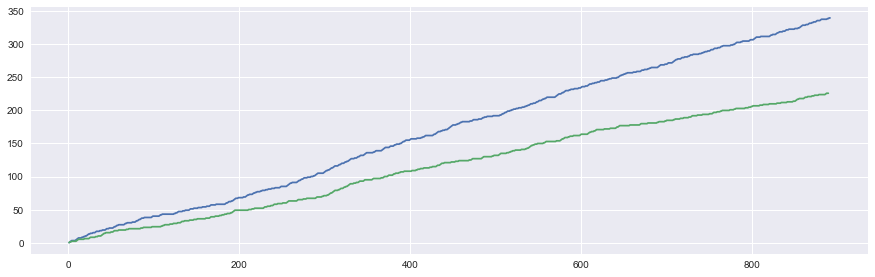

In [71]:
plt.figure(1,figsize = (15,10))
plt.subplot(211)
plt.plot(titan.PassengerId,titan.Survived.cumsum())
plt.subplot(211)
plt.plot(titan.PassengerId,titan.Survived_pred.cumsum())

In [72]:
titan[titan.hypothesis < 60].Survived.value_counts()

0    404
1     79
Name: Survived, dtype: int64

In [73]:
demo = []
for i in range(len(test)):
    if test.hypothesis[i]<61:
        demo.append(0)
    elif test.hypothesis[i]>60:
        demo.append(1)

In [74]:
sub = pd.DataFrame(test.PassengerId)
sub['Survived'] = demo
sub.to_csv('submission_final.csv',index = None)

###### well,it is shocking that even a trivial method like this gave an prediction accuracy of 68.